In [ ]:
import math
import os
import shutil

import cv2
# Evita problemas de backend ao salvar plots em ambiente sem interface
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from brisque import BRISQUE
from tqdm import tqdm

In [ ]:
pwd = os.getcwd()
# Dataset
base_path = os.path.abspath(os.path.join(pwd, '..', '..', 'data', 'ships_v10i'))
# Splits que queremos explorar
splits = ["train", "valid", "test"]

In [ ]:
import os
import random

import cv2
import matplotlib.pyplot as plt


def sample_image(base_path, split):
    """
    Retorna uma imagem aleatória do split especificado.
    
    Args:
        base_path (str): Caminho base para os dados.
        split (str): Nome do split (por exemplo, 'train', 'valid' ou 'test').
        
    Returns:
        tuple: (imagem em RGB, nome do arquivo escolhido)
    """
    images_dir = os.path.join(base_path, split, "images")
    arquivos = [f for f in os.listdir(
        images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not arquivos:
        raise FileNotFoundError(f"Nenhuma imagem encontrada em {images_dir}")

    arquivo_escolhido = random.choice(arquivos)
    caminho_imagem = os.path.join(images_dir, arquivo_escolhido)

    imagem = cv2.imread(caminho_imagem)
    if imagem is None:
        raise ValueError(f"Erro ao ler a imagem: {caminho_imagem}")

    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    return imagem_rgb, arquivo_escolhido

In [ ]:
def read_label(base_path, split, image_filename):
    """
    Lê o arquivo de label correspondente à imagem.
    
    Considera que o arquivo de label tem o mesmo nome da imagem, mas com extensão .txt.
    """
    label_filename = os.path.splitext(image_filename)[0] + ".txt"
    labels_dir = os.path.join(base_path, split, "labels")
    label_path = os.path.join(labels_dir, label_filename)

    if not os.path.exists(label_path):
        raise FileNotFoundError(
            f"Arquivo de label não encontrado: {label_path}")

    with open(label_path, "r") as file:
        lines = file.readlines()

    # Retorna as linhas não vazias
    return [line.strip() for line in lines if line.strip()]

In [ ]:
def process_label(label_line, image_shape):
    """
    Processa uma linha de label (formato YOLO) e converte coordenadas normalizadas para pixel.
    
    Formato esperado: 
        class x_center y_center width height
    
    Args:
        label_line (str): Linha do arquivo de label.
        image_shape (tuple): (altura, largura, canais) da imagem.
    
    Retorna:
        dict: {'class': int, 'x_min': int, 'y_min': int, 'x_max': int, 'y_max': int}
    """
    partes = label_line.split()
    if len(partes) != 5:
        raise ValueError("Linha de label inválida: " + label_line)

    class_id = int(partes[0])
    x_center_norm = float(partes[1])
    y_center_norm = float(partes[2])
    width_norm = float(partes[3])
    height_norm = float(partes[4])

    height_img, width_img = image_shape[:2]
    x_center = x_center_norm * width_img
    y_center = y_center_norm * height_img
    box_width = width_norm * width_img
    box_height = height_norm * height_img

    x_min = int(x_center - box_width / 2)
    y_min = int(y_center - box_height / 2)
    x_max = int(x_center + box_width / 2)
    y_max = int(y_center + box_height / 2)

    return {"class": class_id, "x_min": x_min, "y_min": y_min, "x_max": x_max, "y_max": y_max}

In [ ]:


def extract_objects(image, boxes):
    """
    Dado a imagem e uma lista de caixas (bounding boxes), extrai os objetos e retorna uma lista de imagens recortadas.
    
    Args:
        image (ndarray): Imagem original.
        boxes (list): Lista de dicionários com as coordenadas dos objetos.
        
    Retorna:
        list: Lista de imagens dos objetos extraídos.
    """
    objetos = []
    for box in boxes:
        # Garante que os índices estejam dentro dos limites da imagem
        x_min = max(box["x_min"], 0)
        y_min = max(box["y_min"], 0)
        x_max = min(box["x_max"], image.shape[1])
        y_max = min(box["y_max"], image.shape[0])

        objeto = image[y_min:y_max, x_min:x_max]
        objetos.append(objeto)
    return objetos

In [ ]:
for split in splits:
    print(f"\n Analisando o split {split}")
    # Amostra uma imagem aleatória do split
    imagem, nome_arquivo = sample_image(base_path, split)
    print(f"Imagem selecionada: {nome_arquivo} no split {split}")

    # Lê o arquivo de label correspondente
    linhas_label = read_label(base_path, split, nome_arquivo)

    # Processa cada linha do label para obter as caixas delimitadoras
    caixas = []
    for linha in linhas_label:
        caixa = process_label(linha, imagem.shape)
        caixas.append(caixa)

    # Opcional: desenha as caixas na imagem completa para visualização
    imagem_com_caixas = imagem.copy()
    for caixa in caixas:
        cv2.rectangle(imagem_com_caixas, (caixa["x_min"], caixa["y_min"]), (
            caixa["x_max"], caixa["y_max"]), (255, 0, 0), 2)

    # Exibe a imagem completa com as caixas delimitadoras
    plt.figure(figsize=(8, 8))
    plt.imshow(imagem_com_caixas)
    plt.title(f"Imagem completa: {nome_arquivo}")
    plt.axis("off")
    plt.show()

    # Extrai os objetos da imagem com base nas caixas
    objetos_extraidos = extract_objects(imagem, caixas)

    # Exibe os objetos extraídos
    n_objetos = len(objetos_extraidos)
    if n_objetos > 0:
        plt.figure(figsize=(15, 5))
        for i, obj in enumerate(objetos_extraidos):
            plt.subplot(1, n_objetos, i + 1)
            plt.imshow(obj)
            plt.title(f"Objeto {i+1}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()
    else:
        print("Nenhum objeto extraído.")

In [ ]:
def get_brisque_score(image):
    """
    Calcula o score BRISQUE para a imagem passada.
    
    Args:
        image (ndarray): Imagem em formato RGB.
        
    Retorna:
        float: Score BRISQUE. Menores valores indicam melhor qualidade.
    """
    brisque_obj = BRISQUE()
    score = brisque_obj.score(image)
    return score

In [ ]:
# Para cada split, amostra uma imagem, extrai os objetos e calcula o score BRISQUE de cada objeto
for split in splits:
    print(f"\nAnalisando o split: {split}")

    # Amostra uma imagem aleatória do split
    imagem, nome_arquivo = sample_image(base_path, split)
    print(f"Imagem selecionada: {nome_arquivo}")

    # Lê o label correspondente à imagem e processa as caixas delimitadoras
    linhas_label = read_label(base_path, split, nome_arquivo)
    caixas = [process_label(linha, imagem.shape) for linha in linhas_label]

    # Desenha as caixas na imagem para visualização
    imagem_com_caixas = imagem.copy()
    for caixa in caixas:
        cv2.rectangle(imagem_com_caixas, (caixa["x_min"], caixa["y_min"]),
                      (caixa["x_max"], caixa["y_max"]), (255, 0, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(imagem_com_caixas)
    plt.title(f"Imagem completa: {nome_arquivo}")
    plt.axis("off")
    plt.show()

    # Extrai os objetos com base nas caixas
    objetos_extraidos = extract_objects(imagem, caixas)

    # Para cada objeto extraído, calcula e exibe o score BRISQUE
    for i, obj in enumerate(objetos_extraidos):
        score = get_brisque_score(obj)
        print(f"Objeto {i+1} no split '{split}': BRISQUE Score = {score:.2f}")
        plt.figure(figsize=(4, 4))
        plt.imshow(obj)
        plt.title(f"Objeto {i+1}\nBRISQUE: {score:.2f}")
        plt.axis("off")
        plt.show()

In [ ]:
# Cria uma lista para armazenar os resultados
results = []

if not os.path.exists("brisque_scores.csv"):
    print("O arquivo 'brisque_scores.csv' já existe. Se deseja recalcular os scores, remova o arquivo manualmente.")

    # Itera sobre cada split
    for split in splits:
        print(f"\nProcessando split: {split}")
        images_dir = os.path.join(base_path, split, "images")
        labels_dir = os.path.join(base_path, split, "labels")

        # Lista todos os arquivos de imagem do split
        image_files = [f for f in os.listdir(
            images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Itera sobre cada imagem com tqdm para acompanhar o progresso
        for image_file in tqdm(image_files, desc=f"Processando imagens no split {split}"):
            image_path = os.path.join(images_dir, image_file)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Erro ao ler a imagem: {image_file}")
                continue

            # Converte a imagem para RGB para o cálculo correto do BRISQUE
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Define o caminho do label correspondente
            label_file = os.path.splitext(image_file)[0] + ".txt"
            label_path = os.path.join(labels_dir, label_file)

            if not os.path.exists(label_path):
                print(
                    f"Arquivo de label não encontrado para a imagem: {image_file}")
                continue

            with open(label_path, "r") as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]

            # Processa cada objeto (linha) do label e calcula o score BRISQUE
            for idx, line in enumerate(lines):
                try:
                    caixa = process_label(line, image.shape)
                    # Corrige os limites da caixa para garantir que estão dentro da imagem
                    x_min = max(caixa["x_min"], 0)
                    y_min = max(caixa["y_min"], 0)
                    x_max = min(caixa["x_max"], image.shape[1])
                    y_max = min(caixa["y_max"], image.shape[0])
                    objeto = image_rgb[y_min:y_max, x_min:x_max]
                    score = get_brisque_score(objeto)
                    results.append({
                        "split": split,
                        "image_file": image_file,
                        "object_index": idx,
                        "brisque_score": score,
                        "class": caixa["class"],
                        "bbox": caixa
                    })
                except Exception as e:
                    print(
                        f"Erro processando objeto {idx} na imagem {image_file}: {e}")

    # Consolida os resultados em um DataFrame
    df_scores = pd.DataFrame(results)

    # Salva os resultados em um arquivo CSV
    csv_filename = "brisque_scores.csv"
    df_scores.to_csv(csv_filename, index=False)
    print(f"\nResultados salvos no arquivo: {csv_filename}")

In [38]:
brisque_scores = pd.read_csv("brisque_scores.csv")
print(f"Total de objetos analisados: {len(brisque_scores)}")

Total de objetos analisados: 4704


Contagem de imagens por categoria de qualidade:
categoria_imagem
Boa      2128
Ruim      529
Misto     194
Name: count, dtype: int64


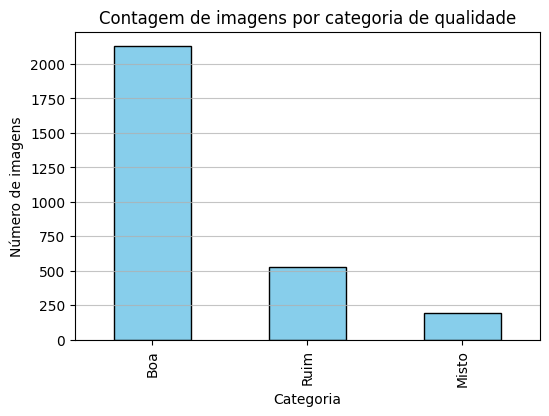

In [39]:
# Adiciona uma coluna "qualidade" aos resultados com base no threshold q3
brisque_scores["qualidade"] = brisque_scores["brisque_score"].apply(
    lambda x: "Boa" if x < q3 else "Ruim")

# Agrupa por (split, image_file) e coleta o conjunto de qualidades presentes em cada imagem
grouped = brisque_scores.groupby(["split", "image_file"])[
    "qualidade"].agg(lambda x: set(x)).reset_index()

# Função para categorizar a imagem:
# Se houver somente um tipo de qualidade, retorna esse mesmo; se houver ambos, retorna "Misto"


def categorize_quality(qual_set):
    return list(qual_set)[0] if len(qual_set) == 1 else "Misto"


grouped["categoria_imagem"] = grouped["qualidade"].apply(categorize_quality)

# Conta a quantidade de imagens em cada categoria (Boa, Ruim ou Misto)
counts = grouped["categoria_imagem"].value_counts()
print("Contagem de imagens por categoria de qualidade:")
print(counts)

# Opcional: Plot de barras
plt.figure(figsize=(6, 4))
counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Contagem de imagens por categoria de qualidade")
plt.xlabel("Categoria")
plt.ylabel("Número de imagens")
plt.grid(axis="y", alpha=0.75)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que df['brisque'] contenha os valores de BRISQUE
q3 = brisque_scores['brisque_score'].quantile(
    0.75)  # Usaremos Q3 como threshold


def categorize(score, q3):
    return 'Boa' if score < q3 else 'Ruim'


print(f"Threshold (Q3): {q3:.2f}")
print(brisque_scores['brisque_score'].value_counts())

# Plot do histograma com a linha do threshold
plt.figure(figsize=(8, 5))
plt.hist(brisque_scores['brisque_score'], bins=50,
         color="skyblue", edgecolor="black")
plt.axvline(q3, color="red", linestyle="dashed",
            linewidth=2, label=f"L (Q3 = {q3:.2f})")
plt.title("Histograma dos Scores BRISQUE")
plt.xlabel("Score BRISQUE")
plt.ylabel("Frequência")
plt.grid(axis="y", alpha=0.75)
plt.legend()
plt.show()

In [ ]:
# Define a pasta de destino para o novo dataset com qualidade reclassificada
new_base_path = base_path + "_quality"

# Cria a estrutura de pastas (train, valid, test com subpastas images e labels)
for split in splits:
    for sub in ["images", "labels"]:
        os.makedirs(os.path.join(new_base_path, split, sub), exist_ok=True)

print("Estrutura do novo dataset criada em:", new_base_path)

In [ ]:
# Cria um dicionário para facilitar a consulta dos scores,
# indexando por (split, image_file, object_index)
score_dict = {
    (row["split"], row["image_file"], row["object_index"]): row["brisque_score"]
    for _, row in brisque_scores.iterrows()
}
print("Dicionário de scores criado. Total de objetos:", len(score_dict))

In [ ]:
import os

for split in splits:
    print(f"\nAtualizando split: {split}")
    images_dir = os.path.join(base_path, split, "images")
    labels_dir = os.path.join(base_path, split, "labels")
    new_images_dir = os.path.join(new_base_path, split, "images")
    new_labels_dir = os.path.join(new_base_path, split, "labels")

    image_files = [f for f in os.listdir(
        images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for image_file in tqdm(image_files, desc=f"Processando {split}"):
        # Copia a imagem para o novo dataset
        shutil.copy(os.path.join(images_dir, image_file),
                    os.path.join(new_images_dir, image_file))

        # Define os caminhos dos arquivos de label
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(labels_dir, label_file)
        new_label_path = os.path.join(new_labels_dir, label_file)

        # Se o label não existir, pula para a próxima imagem
        if not os.path.exists(label_path):
            continue

        # Lê o arquivo de label original
        with open(label_path, "r") as f:
            lines = [line.strip() for line in f if line.strip()]

        new_lines = []
        for idx, line in enumerate(lines):
            partes = line.split()
            if len(partes) != 5:
                continue  # pula linhas em formato inesperado

            # Recupera o score do objeto a partir do dicionário criado
            key = (split, image_file, idx)
            if key not in score_dict:
                print(f"Score não encontrado para {key}")
                continue
            score = score_dict[key]

            # Se o score for menor que q3, a qualidade é "Boa" (classe 1); caso contrário, "Ruim" (classe 0)
            nova_classe = 1 if score < q3 else 0
            novos_valores = [str(nova_classe)] + partes[1:]
            new_lines.append(" ".join(novos_valores))

        # Salva o novo arquivo de label no novo dataset
        with open(new_label_path, "w") as f:
            f.write("\n".join(new_lines))

print("\nDataset atualizado salvo em:", new_base_path)

# Define os caminhos para cada split do novo dataset
train_path = os.path.join(new_base_path, 'train', 'images')
val_path = os.path.join(new_base_path, 'valid', 'images')
test_path = os.path.join(new_base_path, 'test', 'images')

# Conteúdo do data.yaml
data_yaml_content = f"""train: {train_path}
val: {val_path}
test: {test_path}

nc: 2
names: ['ruim', 'boa']

roboflow:
  workspace: tcc-3hnic
  project: ships-dxbbh
  version: 10
  license: Private
  url: https://universe.roboflow.com/tcc-3hnic/ships-dxbbh/dataset/10
"""

# Caminho para salvar o data.yaml no novo dataset
yaml_path = os.path.join(new_base_path, 'data.yaml')
with open(yaml_path, 'w') as f:
    f.write(data_yaml_content)

print("data.yaml gerado em:", yaml_path)